In [30]:
import os
import cv2
import numpy as np
import traceback
import xml.etree.ElementTree as ET

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

# Parse .xml to .txt

In [8]:
VOC_CLASSES = (    # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct         = {}
        difficult          = int(obj.find('difficult').text)
        if difficult == 1:
            # print(filename)
            continue
        obj_struct['name'] = obj.find('name').text
        bbox               = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text)),
                              int(float(bbox.find('ymax').text))]
        objects.append(obj_struct)

    return objects

def parse_dir(dir_annotations, dir_op):
    file_op = open(dir_op,'w')
    xml_files = os.listdir(dir_annotations)
    for i, xml_file in enumerate(xml_files):
        #if (i % 100 == 0):
        #    print (' - i:', i)
        try:
            results    = parse_rec(os.path.join(dir_annotations,xml_file))
            image_path = xml_file.split('.')[0] + '.jpg'
            if len(results)==0:
                print(' - No useful anno : ', xml_file)
                continue

            file_op.write(image_path)

            for result in results:
                class_name = result['name']
                bbox       = result['bbox']
                class_name = VOC_CLASSES.index(class_name)
                file_op.write(' '+str(bbox[0])+' '+str(bbox[1])+' '+str(bbox[2])+' '+str(bbox[3])+' '+str(class_name))

            file_op.write('\n')
        except Exception:
            traceback.print_exc()
            print (' - Error : File ID',i, ' || Name : ', xml_file)
    
    file_op.close()
        

if __name__ == "__main__":
    dir_annotations = '../data/VOCdevkit_trainval/VOC2007/Annotations'
    if (1):
        dir_op      = os.path.join(dir_annotations, '../anno_trainval.txt')
        print (dir_op)
    
    parse_dir(dir_annotations, dir_op)
    
    

../data/VOCdevkit_trainval/VOC2007/Annotations/../anno_trainval.txt
 - i: 0
 - i: 100
 - i: 200
 - i: 300
 - i: 400
 - i: 500
 - i: 600
 - i: 700
 - i: 800
 - i: 900
 - i: 1000
 - i: 1100
 - i: 1200
 - i: 1300
 - i: 1400
 - i: 1500
 - i: 1600
 - i: 1700
 - i: 1800
 - i: 1900
 - i: 2000
 - i: 2100
 - i: 2200
 - i: 2300
 - i: 2400
 - i: 2500
 - i: 2600
 - i: 2700
 - i: 2800
 - i: 2900
 - i: 3000
 - i: 3100
 - i: 3200
 - i: 3300
 - i: 3400
 - i: 3500
 - i: 3600
 - i: 3700
 - i: 3800
 - i: 3900
 - i: 4000
 - i: 4100
 - i: 4200
 - i: 4300
 - i: 4400
 - i: 4500
 - i: 4600
 - i: 4700
 - i: 4800
 - i: 4900
 - i: 5000


# Create PyTorch Loaders

 - Total :  5011
 - fname : 007187.jpg
 - path :  ../data/VOCdevkit_trainval/VOC2007/JPEGImages/007187.jpg


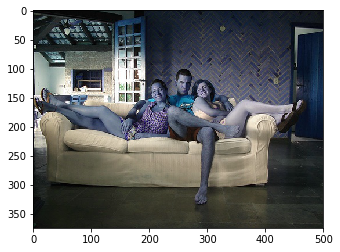

In [37]:
class YoloDataset(data.Dataset):
    
    def __init__(self, dir_data, file_annotations
                 , train
                 , image_size, grid_num
                 , flag_augm
                 , transform):
        
        self.dir_data   = dir_data
        self.dir_img    = os.path.join(dir_data, 'JPEGImages')
        self.train      = train
        self.transform  = transform
        
        self.fnames     = []
        self.boxes      = []
        self.labels     = []
        self.mean       = (123,117,104) # RGB ([How?])
        
        self.grid_num   = grid_num
        self.image_size = image_size
        self.flag_augm  = flag_augm

        with open(file_annotations) as f:
            for line in f.readlines():
                splited   = line.strip().split()
                self.fnames.append(splited[0])
                num_boxes = (len(splited) - 1) // 5
                box       = []
                label     = []
                for i in range(num_boxes):
                    x  = float(splited[1+5*i])
                    y  = float(splited[2+5*i])
                    x2 = float(splited[3+5*i])
                    y2 = float(splited[4+5*i])
                    c  = splited[5+5*i]
                    box.append([x,y,x2,y2])
                    label.append(int(c)+1)
                self.boxes.append(torch.Tensor(box))
                self.labels.append(torch.LongTensor(label))
                
        self.num_samples = len(self.boxes)
    
    def __getitem__(self,idx, verbose=0):
        fname  = self.fnames[idx]
        img    = cv2.imread(os.path.join(self.dir_img, fname))
        boxes  = self.boxes[idx].clone()
        labels = self.labels[idx].clone()
        
        if (1):
            print (' - fname :', fname)
            print (' - path : ', os.path.join(self.dir_img, fname))
        
        if self.train:
            if (self.flag_augm == 1):
                if (0):
                    img = self.random_bright(img)
                img, boxes       = self.random_flip(img, boxes)
                img,boxes        = self.randomScale(img,boxes)
                img              = self.randomBlur(img)
                img              = self.RandomBrightness(img)
                img              = self.RandomHue(img)
                img              = self.RandomSaturation(img)
                img,boxes,labels = self.randomShift(img,boxes,labels)
                img,boxes,labels = self.randomCrop(img,boxes,labels)

        h,w,_  = img.shape
        plt.imshow(img)
        boxes  /= torch.Tensor([w,h,w,h]).expand_as(boxes)
        img    = self.BGR2RGB(img) #because pytorch pretrained model use RGB
        #img    = self.subMean(img,self.mean) 
        img    = cv2.resize(img,(self.image_size,self.image_size))
        target = self.encoder(boxes,labels) # 7x7x30
        for t in self.transform:
            img = t(img)

        return img,target
    
    def __len__(self):
        return self.num_samples
    
    def encoder(self,boxes,labels):
        '''
        boxes (tensor) [[x1,y1,x2,y2],[]]
        labels (tensor) [...]
        return 7x7x30
        '''
        
        target    = torch.zeros((self.grid_num, self.grid_num,30))
        cell_size = 1./self.grid_num
        wh        = boxes[:,2:] - boxes[:,:2]
        cxcy      = (boxes[:,2:] + boxes[:,:2])/2
        for i in range(cxcy.size()[0]):
            cxcy_sample                       = cxcy[i]
            ij                                = (cxcy_sample/cell_size).ceil()-1 #
            target[int(ij[1]),int(ij[0]),4]   = 1
            target[int(ij[1]),int(ij[0]),9]   = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1
            xy                                = ij*cell_size # The relative coordinates of the upper left corner of the matched mesh
            delta_xy                          = (cxcy_sample -xy)/cell_size
            target[int(ij[1]),int(ij[0]),2:4] = wh[i]
            target[int(ij[1]),int(ij[0]),:2]  = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
            
        return target
    
    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    def BGR2HSV(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    def HSV2BGR(self,img):
        return cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    
    def subMean(self,bgr,mean):
        mean = np.array(mean, dtype=np.float32)
        bgr  = bgr - mean
        return bgr
    
    

if __name__ == "__main__":
    dir_annotations  = '../data/VOCdevkit_trainval/VOC2007'
    file_annotations = '../data/VOCdevkit_trainval/VOC2007/anno_trainval.txt'
    image_size       = 448
    grid_num         = 14
    flag_augm        = 0
    train            = True
    
    dataset_train = YoloDataset(dir_annotations, file_annotations
                                , train
                                , image_size, grid_num
                                , flag_augm
                                , transform = [transforms.ToTensor()] )
    
    print (' - Total : ', len(dataset_train))
    idx = np.random.randint(len(dataset_train))
    X,Y = dataset_train[idx]
    
    
#     train_loader = DataLoader(train_dataset,batch_size=1,shuffle=False,num_workers=0)
#     train_iter = iter(train_loader)
#     for i in range(100):
#         img,target = next(train_iter)
#         print(img,target)

torch.Size([448, 448, 3])


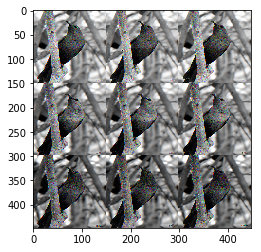

In [36]:
X.shape
tmp = np.reshape(X,[448,448,3])
print (tmp.shape)
plt.imshow(tmp)